# **Our Project's topic:**
Detecting whether a person's photo is Real or not.

# **About the Data set we have used:**
This dataset consists of all 70k REAL faces from the Flickr dataset collected by Nvidia, as well as 70k fake faces sampled from the 1 Million FAKE faces (generated by StyleGAN).

# **Real Life applications that our project can help in:**
- Can be used by social media platforms to detect whether the person trying to sign up/add a profile photo is real or not.
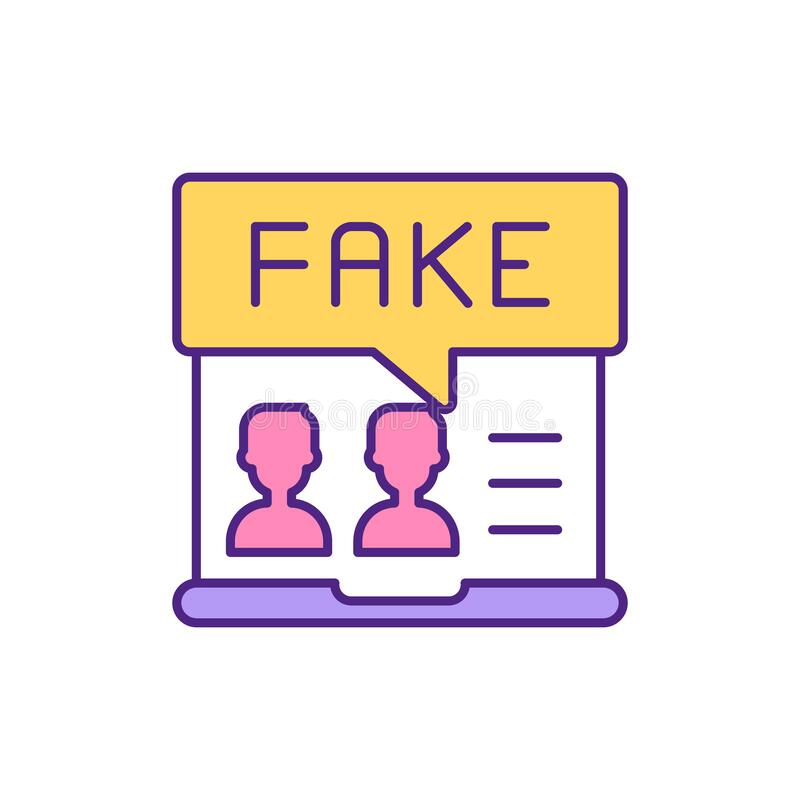
- Can be used by government related websites to detect whether the photos attached to a needed documentations are real or fake to prevent fraud.


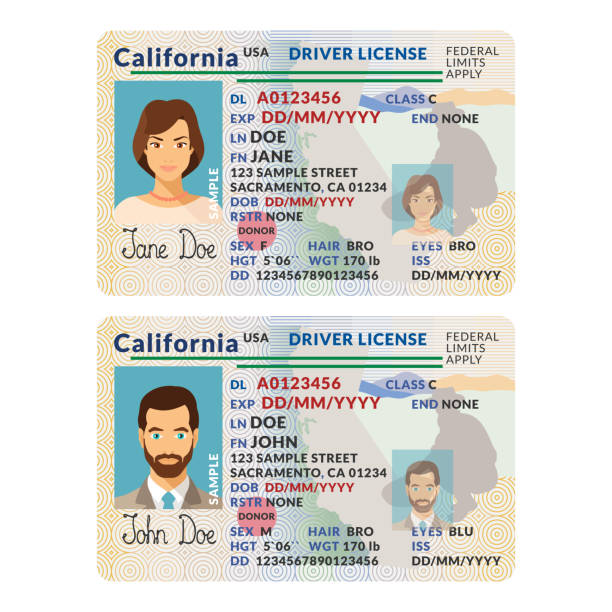
- Dating apps are highly in need to something like this to prevent multiple illegal actions like catfishing which might lead to alot of crimes as pedophilia , harassment and kidnapping.


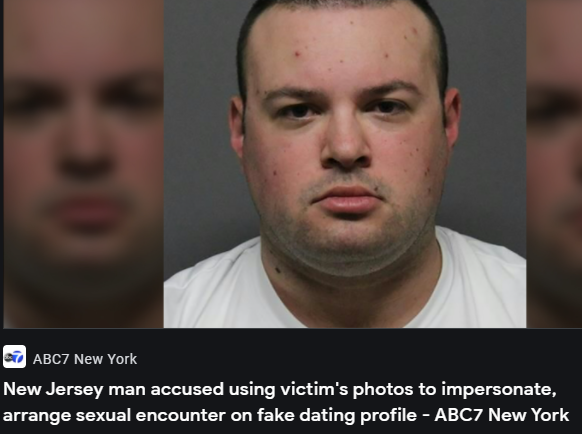 |

# import libraries

In [16]:
import os
import glob
import cv2
import numpy as np
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf

# EDA

#### In the beginning, We will display the data and do some data visualization ..

In [17]:
path  = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/'

In [18]:
dataset = {"image_path":[],"img_status":[],"where":[]}
for where in os.listdir(path):
    for status in os.listdir(path+"/"+where):
        for image in glob.glob(path+where+"/"+status+"/"+"*.jpg"):
            dataset["image_path"].append(image)
            dataset["img_status"].append(status)
            dataset["where"].append(where)
dataset = pd.DataFrame(dataset)
dataset

,image_path,img_status,where
0,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake,valid
1,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake,valid
2,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake,valid
3,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake,valid
4,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake,valid
...,...,...,...
139995,/kaggle/input/140k-real-and-fake-faces/real_vs...,real,train
139996,/kaggle/input/140k-real-and-fake-faces/real_vs...,real,train
139997,/kaggle/input/140k-real-and-fake-faces/real_vs...,real,train
139998,/kaggle/input/140k-real-and-fake-faces/real_vs...,real,train


In [19]:
dataset.value_counts("img_status")

img_status
fake    70000
real    70000
dtype: int64

Real: 70000,
Fake: 70000



/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


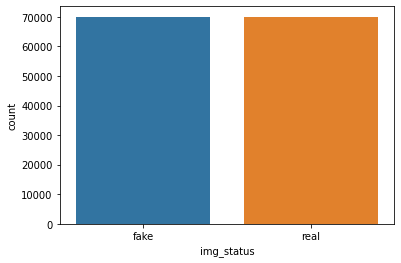

In [20]:
real = dataset.value_counts("img_status")[1]
fake = dataset.value_counts("img_status")[0]

print(f"Real: {real},\nFake: {fake}\n")
sns.countplot(dataset["img_status"])
plt.show()

#### As we can see the data is balanced, We have 70000 image for each category.

#### And here is some random samples from the data .. 

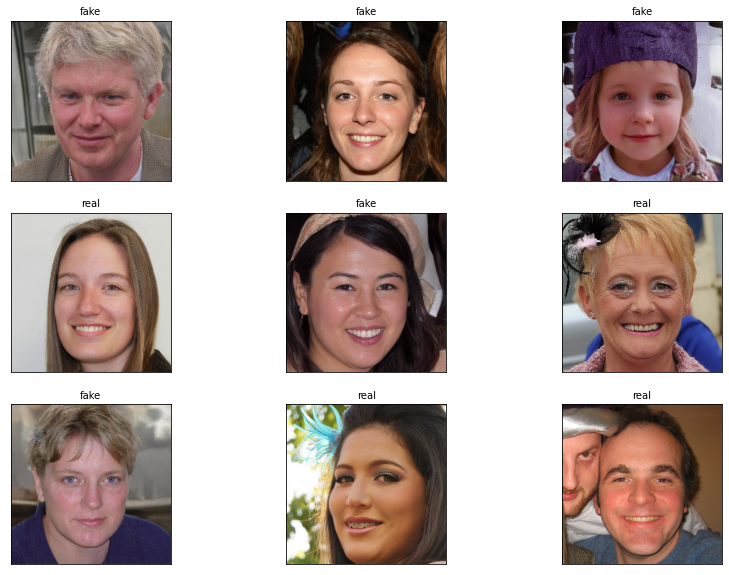

In [21]:
plt.figure(figsize = (14,10))
for i in range(9):
    random = np.random.randint(1,len(dataset))
    plt.subplot(3,3,i+1)
    plt.imshow(plt.imread(dataset.loc[random,"image_path"]))
    plt.title(dataset.loc[random, "img_status"], size = 10) 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

# Preprocessing

#### Know we will split the data by the generator to train,test and validation.

In [22]:
image_gen = ImageDataGenerator()

In [23]:
train_generator = image_gen.flow_from_directory(
    path + 'train/',
    target_size=(224, 224),
    batch_size=100,
    color_mode='grayscale',
    class_mode='binary'
)

Found 100000 images belonging to 2 classes.


In [24]:
valid_generator = image_gen.flow_from_directory(
    path + 'valid/',
    target_size=(224, 224),
    batch_size=100,
    color_mode='grayscale',
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.


In [25]:
test_generator = image_gen.flow_from_directory(
    path + 'test/',
    target_size=(224, 224),
    batch_size=1,
    color_mode='grayscale',
    shuffle = False,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.


# Modeling

### Classify The Model

In [26]:
densenet = DenseNet121( weights=None, include_top=False, input_shape=(224,224,1) )

In [27]:
model = Sequential([ 
        densenet,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])

In [28]:
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7031232   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 7,032,257
Trainable params: 6,948,609
Non-trainable params: 83,648
_________________________________________________________________


In [30]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = (100000//100),
    validation_data = valid_generator,
    validation_steps = (20000//100),
    epochs = 10
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1000/1000 [==============================] - 705s 696ms/step - loss: 0.4860 - accuracy: 0.7606 - val_loss: 1.1695 - val_accuracy: 0.5246
Epoch 2/10
1000/1000 [==============================] - 560s 560ms/step - loss: 0.2441 - accuracy: 0.8981 - val_loss: 0.3067 - val_accuracy: 0.8734
Epoch 3/10
1000/1000 [==============================] - 572s 572ms/step - loss: 0.1328 - accuracy: 0.9475 - val_loss: 0.4238 - val_accuracy: 0.8321
Epoch 4/10
1000/1000 [==============================] - 574s 574ms/step - loss: 0.0827 - accuracy: 0.9688 - val_loss: 0.1736 - val_accuracy: 0.9316
Epoch 5/10
1000/1000 [==============================] - 574s 574ms/step - loss: 0.0567 - accuracy: 0.9787 - val_loss: 0.4490 - val_accuracy: 0.8080
Epoch 6/10
1000/1000 [==============================] - 575s 575ms/step - loss: 0.0406 - accuracy: 0.9849 - val_loss: 0.3544 - val_accuracy: 0.8929
Epoch 7/10
1000/1000 [==============================] - 573s 573ms/step - loss: 0.0323 - accuracy: 0.9880 - val_

In [31]:
model.save('Real VS Fake.h5')

In [32]:
#load_model('./Real VS Fake.h5')

### Model evaluation

In [33]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

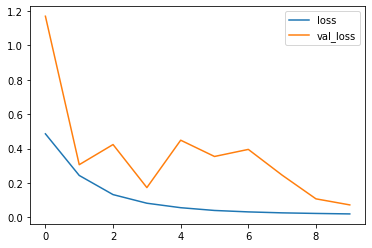

In [34]:
losses[['loss','val_loss']].plot()

<AxesSubplot:>

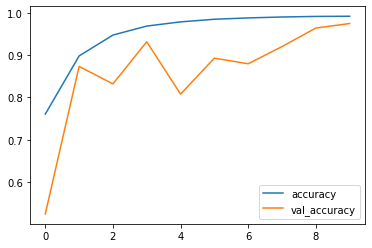

In [35]:
losses[['accuracy','val_accuracy']].plot()

### prediction

In [36]:
y_pred = model.predict(test_generator)
y_test = test_generator.classes

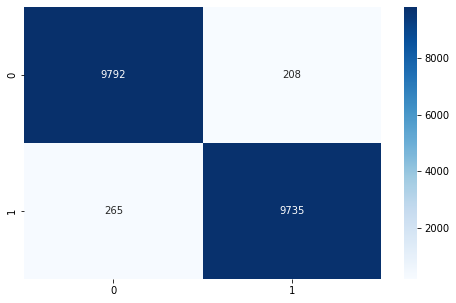

In [38]:
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred.round()), annot = True,fmt="d",cmap = "Blues")
plt.show()

In [39]:
print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))

ROC-AUC Score: 0.9972028450000001
AP Score: 0.997141208475286


In [40]:
print(metrics.classification_report(y_test, y_pred > 0.5))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     10000
           1       0.98      0.97      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000



#### Let me Know your opinion about my project ^_^